<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/unet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagens segmentadas e classificação em cnn

Último treinamento: 06/01/2026

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder='/content/drive/MyDrive/CAI_SWTB/train'

In [ ]:
input_folder = "/content/drive/MyDrive/CAI_SWTB/train/Faulty"
output_folder = "/content/drive/MyDrive/CAI_SWTB/train/seg_faulty"

# Criar a pasta de saída se não existir
os.makedirs(output_folder, exist_ok=True)

# Processar todas as imagens na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imagens
        image_path = os.path.join(input_folder, filename)

        # Carregar imagem
        image = cv2.imread(image_path)
        if image is None:
            continue  # Ignorar arquivos inválidos

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Redimensionar para manter o desempenho
        image_resized = cv2.resize(image, (image.shape[1] // 1, image.shape[0] // 1))

        # Converter para o formato adequado para clustering
        image_data = image_resized.reshape((-1, 1))

        # Aplicar K-means clustering
        kmeans = KMeans(n_clusters=2, random_state=256, n_init=10)
        kmeans.fit(image_data)

        # Criar a máscara binária
        mask = kmeans.labels_.reshape(image_resized.shape[:2])

        # Salvar a máscara como imagem
        output_path = os.path.join(output_folder, f"seg_{filename}")
        cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

print("Processamento concluído! As imagens segmentadas foram salvas.")

Processamento concluído! As imagens segmentadas foram salvas.


In [ ]:
input_folder = "/content/drive/MyDrive/CAI_SWTB/train/Healthy"
output_folder = "/content/drive/MyDrive/CAI_SWTB/train/seg_healthy"

# Criar a pasta de saída se não existir
os.makedirs(output_folder, exist_ok=True)

# Processar todas as imagens na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imagens
        image_path = os.path.join(input_folder, filename)

        # Carregar imagem
        image = cv2.imread(image_path)
        if image is None:
            continue  # Ignorar arquivos inválidos

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Redimensionar para manter o desempenho
        image_resized = cv2.resize(image, (image.shape[1] // 1, image.shape[0] // 1))

        # Converter para o formato adequado para clustering
        image_data = image_resized.reshape((-1, 1))

        # Aplicar K-means clustering
        kmeans = KMeans(n_clusters=2, random_state=256, n_init=10)
        kmeans.fit(image_data)

        # Criar a máscara binária
        mask = kmeans.labels_.reshape(image_resized.shape[:2])

        # Salvar a máscara como imagem
        output_path = os.path.join(output_folder, f"seg_{filename}")
        cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

print("Processamento concluído! As imagens segmentadas foram salvas.")

Processamento concluído! As imagens segmentadas foram salvas.


In [ ]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
#image resolution
image_width = 128
image_height = 128
channels = 3 #rgb

train_files = []
i=0
for classes in ['seg_faulty', 'seg_healthy']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

/content/drive/MyDrive/CAI_SWTB/train/seg_faulty
/content/drive/MyDrive/CAI_SWTB/train/seg_healthy


In [ ]:
i = 0

valid_extensions=(".jpg", ".jpeg", ".png", ".bmp")

for classes in ['seg_faulty', 'seg_healthy']: #catregorias das imagens
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes))
     if f.lower().endswith(valid_extensions) and
             os.path.isfile(os.path.join(folder, classes, f))]

    #if os.path.isfile(os.path.join(folder, classes, f))] #seleciona as imagens e ignora pastas
    for _file in onlyfiles: #Percorre os arquivos da pasta
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width)) #redimenciona a iamgem
        x = img_to_array(img)

        dataset[i] = x #armazenando os dados
        mapping = {'seg_faulty': 0 , 'seg_healthy': 1} #dicionario
        y_dataset.append(mapping[classes])  #rotulo das imagens

        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


In [ ]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [ ]:
classes = ['Faulty', 'Healthy']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

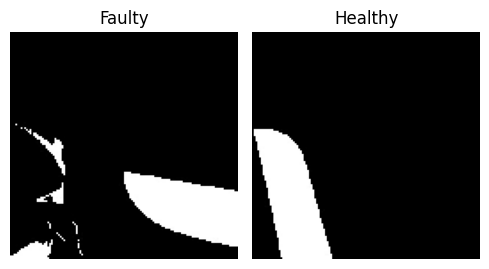

In [ ]:
# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 15))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

In [ ]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [ ]:
# Ajusta o tamanho do dataset para coincidir com o tamanho menor entre dataset_trimmed e y_dataset_
min_length = min(len(dataset), len(y_dataset_))
dataset_trimmed = dataset[:min_length]
y_dataset_trimmed = y_dataset_[:min_length]

# Verifica se os tamanhos agora estão iguais
assert len(dataset_trimmed) == len(y_dataset_trimmed), "Os tamanhos ainda não são consistentes!"

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_trimmed, test_size=1)

print("Train set size: {}, Test set size: {}".format(len(X_train), len(X_test)))


Train set size: 4199, Test set size: 1


In [ ]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 2100

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 4200
Tamanho do conjunto de teste: 1
Classe 0: 2100 amostras
Classe 1: 2100 amostras


In [ ]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(2, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     8,388,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,582,958 (36.56 MB)

 Trainable params: 9,582,952 (36.56 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'Adam' is not defined

In [ ]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=100, callbacks=[early_stopping], batch_size=64)

NameError: name 'model' is not defined

Problemas com warnings